# 02b Estimation of the SED shape for Auxtel

- author Sylvie Dagoret-Campagne
- creation date : 2023/02/23
- last verification : 2024/01/04

### Use libraries

- getObsAtmo : for atmosphere emulation : https://github.com/LSSTDESC/getObsAtmo/tree/main
- rubinsimphot : a simplified version of rubin_sim : https://github.com/sylvielsstfr/rubinsimphot

**Goal** : shows the sensitivity to the SED slope in some band with color dependence

- simulate many atmospheric conditions
- simulate few SEDs 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os,sys
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'


In [2]:
from scipy import interpolate

In [3]:
from astropy import constants as const
from astropy import units as u

In [4]:
machine_name = os.uname().nodename

if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    print("Set environment for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),"repos/repos_w_2023_44/rubinsimphot/src")
    sys.path.append(newpythonpath)
elif 'dagoret-nb' in machine_name:
    print("Set environment for USDF Rubin Science Platform")
    newpythonpath = os.path.join(os.getenv("HOME"),"repos/repos_w_2023_44/rubinsimphot/src")
    sys.path.append(newpythonpath)  
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environment named conda_py310")
else:
    print(f"Your current machine name is {machine_name}. Check your python environment")

Be sure to run this notebook in conda environment named conda_py310


## Imports dedicated to this work

- import the atmospheric transparency emulator (instead of using libradtran code).
- import rubin sim
- import libPhotometricCorrections : encapsulate uninteresting calculation details

In [5]:
from importlib.metadata import version
the_ver = version('getObsAtmo')
print(f"Version of getObsAtmo : {the_ver}")

Version of getObsAtmo : 0.1.1


In [6]:
from getObsAtmo import ObsAtmo
emul = ObsAtmo()

LSST site name validated as LSST observatory


In [7]:
WL = emul.GetWL()

In [8]:
import sys
sys.path.append('../lib')
#import libAtmosphericFit

In [9]:
# This package encapsulate the calculation on calibration used in this nb
from libPhotometricCorrections_auxtel import *

LSST site name validated as LSST observatory


https://github.com/lsst/rubin_sim_notebooks/blob/main/photometry/calculating_snr.ipynb

In [10]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data import get_data_dir
from rubinsimphot.phot_utils import PhotometricParameters 
from rubinsimphot.site_models import SeeingModel
from rubinsimphot.phot_utils import signaltonoise
from rubinsimphot.phot_utils import calc_neff

In [11]:
def set_photometric_parameters(exptime, nexp, readnoise=None):
    # readnoise = None will use the default (8.8 e/pixel). Readnoise should be in electrons/pixel.
    photParams = PhotometricParameters(exptime=exptime, nexp=nexp, readnoise=readnoise)
    return photParams

In [12]:
def scale_sed(ref_mag, ref_filter, sed):
    fluxNorm = sed.calc_flux_norm(ref_mag, lsst_std[ref_filter])
    sed.multiply_flux_norm(fluxNorm)
    return sed

In [13]:
seeing_model = SeeingModel()
def seeing_at_X(obs_filter, obs_X, atmospheric_seeing_500nm=None, seeing_zenith=None):
    "Return FWHMeff in `obs_filter` at `obs_X`, providing either the seeing @ zenith (in filter) or the FWHM_500"
    if atmospheric_seeing_500nm is not None:
        idx = filterlist.index(obs_filter)
        fwhm_eff = seeing_model(atmospheric_seeing_500nm, obs_X)['fwhmEff'][idx]
    elif seeing_zenith is not None:
        # assume seeing_zenith is in the filter of choice and just approximate for airmass 
        airmass_correction = np.power(obs_X, 0.6)
        fwhm_eff = 1.16 * seeing_zenith * airmass_correction
    else:
        raise ValueErorr('Must specify atmospheric_seeing_500nm or seeing_zenith')
    return fwhm_eff

In [14]:
def calc_snr(sed, obs_filter, obs_skymag, obs_fwhm_eff, obs_X, 
             ref_filter, ref_mag, 
             exptime=15, nexp=2, verbose=False):
    obs_sky = scale_sky(obs_skymag, obs_filter)
    lsst_x = throughput_at_X(obs_X)
    scaled_sed = scale_sed(ref_mag, ref_filter, sed)
    photParams = set_photometric_parameters(exptime, nexp)
    snr = SignalToNoise.calc_snr_sed(scaled_sed, lsst_x[obs_filter], 
                                    obs_sky, lsst_hardware[obs_filter], 
                                    photParams, fwhm_eff=obs_fwhm_eff, 
                                    verbose=verbose)
    return snr

## Configuration

In [15]:
path_rubin_sim_throughput=os.path.join(get_data_dir(),"throughputs/baseline")

In [16]:
darksky = Sed()
darksky.read_sed_flambda(os.path.join(path_rubin_sim_throughput, 'darksky.dat'))

In [17]:
index_sel = np.where(np.logical_and(darksky.wavelen>=WLMIN,darksky.wavelen<WLMAX))[0]
wav = darksky.wavelen[index_sel]
fll = darksky.flambda[index_sel]
darksel = Sed(wavelen=wav, flambda=fll)

Text(0, 0.5, '$F_\\lambda (\\lambda)$')

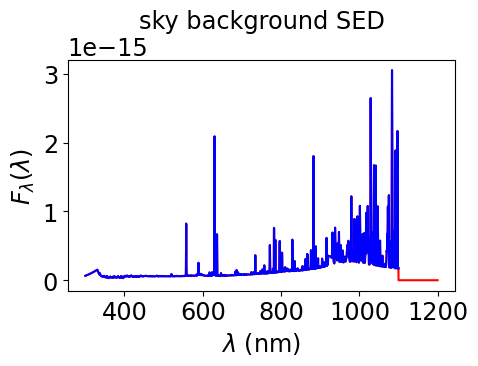

In [18]:
fig, axs = plt.subplots(1,1,figsize=(5,3))
axs.plot(darksky.wavelen,darksky.flambda,'r-')
axs.plot(darksel.wavelen,darksel.flambda,'b-')
axs.set_title("sky background SED")
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_ylabel("$F_\lambda (\lambda)$")

## Chose a Standard atmosphere

In [19]:
am0 =1.20    # airmass
pwv0 = 5.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
tau0= 0.04 # Vertical Aerosol depth (VAOD) 
beta0 = 1.0# Aerosol Angstrom exponent

### Initialisation of Atmospheric corrections

In [20]:
pc = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)

/Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


### Check standard atmosphere

Text(0.5, 1.0, 'Standard atmosphere transmission')

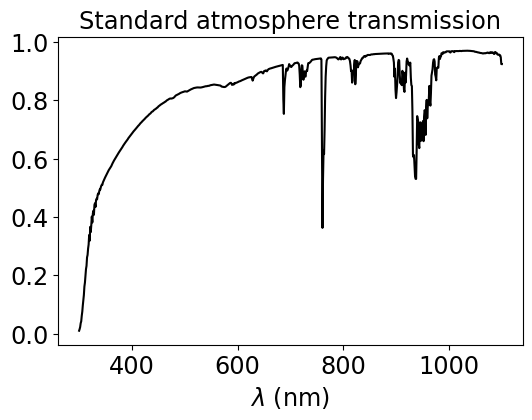

In [21]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
axs.plot(pc.WL,pc.atm_std,'k-')
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Standard atmosphere transmission")

## Pickup an SED

In [22]:
# this will contain attributes calculated for each SED
df_SED = pd.DataFrame(columns=["name","type"])

In [23]:
datadir = get_data_dir()
#sedDir = '/Users/lynnej/other_repos/photometry_sample'
sedDir = os.path.join(datadir,'photometry_sample')

sedtypes = ['galaxies', 'quasar', 'stars'] 
sedtypes_not_used = ['sn', 'photoZ_outliers', 'white_dwarf']
sedtypes = sedtypes + sedtypes_not_used

NSEDTYPES = len(sedtypes)

# dictionnary indexed by sed-name
seds = {}      # dictionnary that will contain the `rubin_sim` seds-Flambdas
sedsfnu = {}   # dictionnary that will contain the `rubin_sim` seds-Fnu
sedtypeslists = {}  # dictionnary that contain the SED type
count_sed =0

# loop on SED type
for idx,s in enumerate(sedtypes):
    sedtypelist = []
    # loop on object sed in SED type list
    filenames = os.listdir(os.path.join(sedDir, s))
    for f in filenames:
        name = f.replace('.dat', '').replace('.sed', '')
        
        if name == "m3.0Full":
            continue
            
        seds[name] = Sed()
        seds[name].read_sed_flambda(os.path.join(sedDir, s, f))
        sedsfnu[name]= Sed()
    
        # save the name of the sed in the list
        sedtypelist.append(name) 
        df_SED.loc[count_sed] = [name,s]
        count_sed+=1
        
    # save the above list in a dictionary
    sedtypeslists[s] =  sedtypelist
        


In [24]:
df_SED=df_SED.set_index('name')
df_SED

,type
name,
Sa_template_norm,galaxies
Sdm_template_norm0,galaxies
Ell2_template_norm,galaxies
quasar,quasar
km10_5250.fits_g45,stars
km10_4500.fits_g45,stars
km10_6000.fits_g45,stars
km10_7250.fits_g45,stars
km10_6500.fits_g45,stars


In [25]:
sed_name = 'Sa_template_norm'

In [26]:
z=0
seds[sed_name].redshift_sed(z)

In [27]:
# Scale spectrum and recalculate magnitudes.
z = 20.0

flux_norm = seds[sed_name].calc_flux_norm(z, pc.bandpass_total_std['z'])
seds[sed_name].multiply_flux_norm(flux_norm)

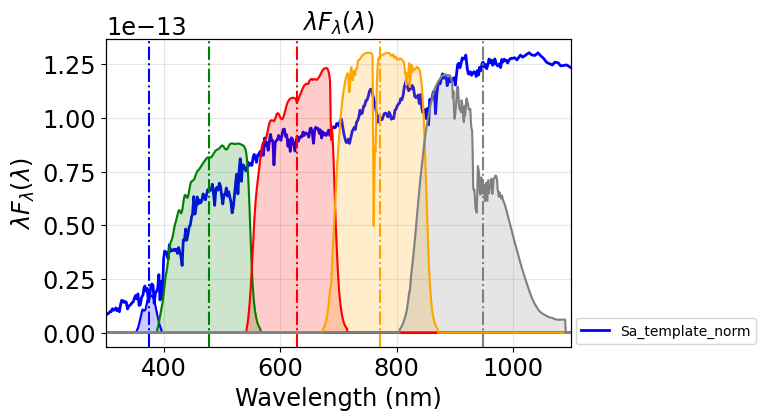

In [28]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(seds[sed_name].wavelen, seds[sed_name].flambda * seds[sed_name].wavelen,"b-",label=sed_name,lw=2)
ax.legend(loc=(1.01, 0.01))
ax.set_xlim(300, 1100)
ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$\lambda F_\lambda(\lambda)$")
ax.set_title("$\lambda F_\lambda(\lambda)$")
ax2 = ax.twinx()

for index,f in enumerate(filter_tagnames):
    
    ax2.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    ax2.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    ax2.set_yticks([])

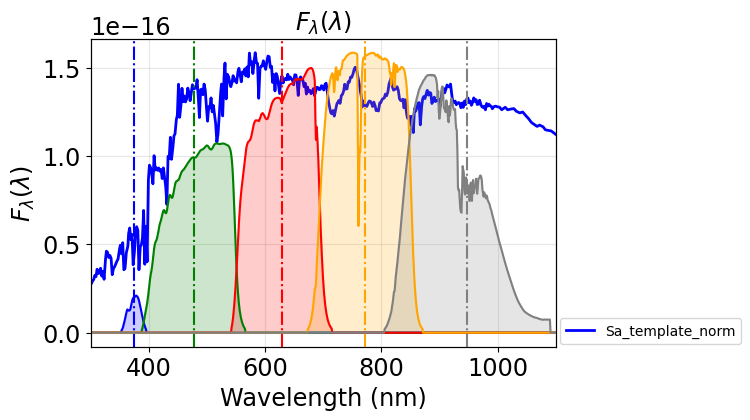

In [29]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(seds[sed_name].wavelen, seds[sed_name].flambda,"b-",label=sed_name,lw=2)
ax.legend(loc=(1.01, 0.01))
ax.set_xlim(300, 1100)
ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$F_\lambda(\lambda)$")
ax.set_title("$F_\lambda (\lambda)$")
ax2 = ax.twinx()

for index,f in enumerate(filter_tagnames):
    
    ax2.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    ax2.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    ax2.set_yticks([])
    

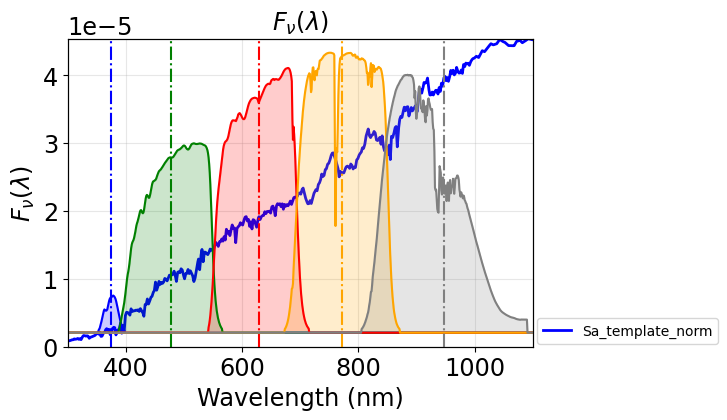

In [30]:
# Plot the seds
fig, ax = plt.subplots(1,1,figsize=(6,4))

wavel,fnu = seds[sed_name].get_sed_fnu()
ax.plot(wavel, fnu,"b-",label=sed_name,lw=2)
ax.legend(loc=(1.01, 0.01))
ax.set_xlim(300, 1100)

ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$F_\\nu (\lambda)$")
ax.set_title("$F_\\nu (\lambda)$")

indexes_sel = np.where(np.logical_and(wavel>WLMIN,wavel<WLMAX))[0]
flmax = np.max(fnu[indexes_sel])
ax.set_ylim(0,flmax)
                       

ax2 = ax.twinx()
for index,f in enumerate(filter_tagnames):
    
    ax2.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    ax2.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    ax2.set_yticks([])
    

# Calculations of magnitude and ADC in standard passband

In [31]:
mags_std = {}
for index,f in enumerate(filter_tagnames) :
    mags_std[f] = seds[sed_name].calc_mag(pc.bandpass_total_std[f])
    
pd.DataFrame(mags_std, index=[sed_name]).T

,Sa_template_norm
u,22.970804
g,21.431571
r,20.709280
i,20.339339
z,20.000000


In [32]:
photoparams = set_photometric_parameters(15, 2 , readnoise=None)
adcs_std = {}
for index,f in enumerate(filter_tagnames) :
    adcs_std[f] = seds[sed_name].calc_adu(pc.bandpass_total_std[f],photoparams)
    
pd.DataFrame(adcs_std, index=[sed_name]).T

,Sa_template_norm
u,98.263036
g,8038.531734
r,16326.546502
i,23938.516128
z,23492.330665


In [33]:
# constant in zero point
F0AB = 3631*(1*u.Jy).cgs.value
Z0PTconst = 2.5*np.log10((F0AB*photoparams.effarea*photoparams.nexp*photoparams.exptime)/(photoparams.gain*const.h.cgs.value))

z0pt_std= {}
for index,f in enumerate(filter_tagnames):
    z0pt_std[f] = Z0PTconst + 2.5*np.log10(pc.all_II0_std[f])
pd.DataFrame(z0pt_std, index=[sed_name]).T    

,Sa_template_norm
u,27.951779
g,31.194512
r,31.241516
i,31.287082
z,30.927315


# Create a series of observations

In [34]:
PWVMIN = 1
PWVMAX = 9
DPWV= PWVMAX-PWVMIN 
NOBS = 100

In [35]:
all_pwv = DPWV*np.random.rand(NOBS) + PWVMIN

In [36]:
pc.CalculateMultiObs(am0,all_pwv,oz0,tau0,beta0)

/Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


## Calculate ADC

In [37]:
# Calculate the standard dark sky zenith magnitudes - for reference
#darksky_mags = {}
#for index,f in enumerate(filter_tagnames):
#    darksky_mags[f] = darksel.calcMag(pc.bandpass_inst[f])
#pd.DataFrame(darksky_mags, index=['Dark sky magnitudes']).round(2)

In [38]:
all_adc = np.zeros(NOBS)
all_ratioII0 = np.zeros(NOBS)
all_subII1 = np.zeros(NOBS)

selected_filter = "z"
for idx,pwv in enumerate(all_pwv):
    lsst_band = pc.coll_bandpass_total_nonstd[idx][selected_filter]
    adcs_nonstd = seds[sed_name].calc_adu(lsst_band,photoparams)
    all_adc[idx] = adcs_nonstd
    all_ratioII0[idx] = pc.allcollperfilter[selected_filter]["II0ratio_nonstd"][idx]
    all_subII1[idx] = pc.allcollperfilter[selected_filter]["II1sub_nonstd"][idx]

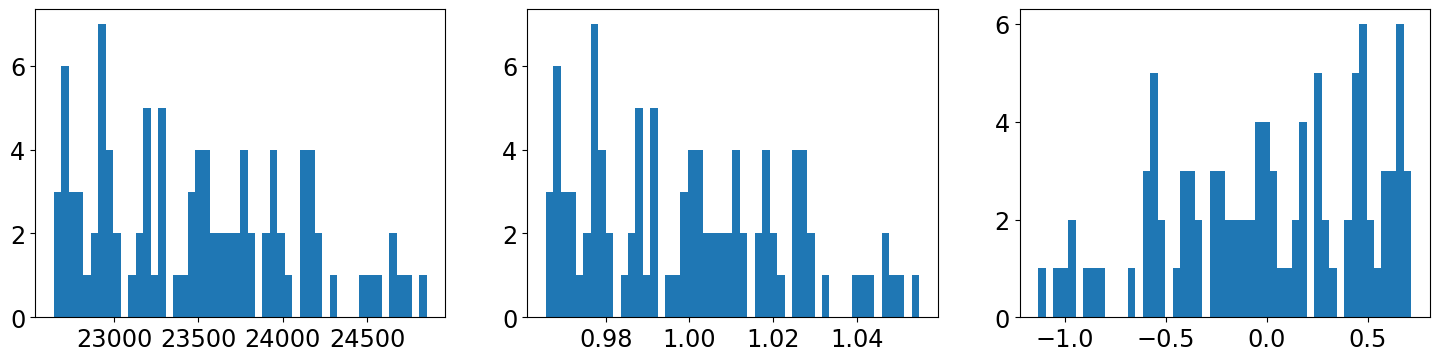

In [39]:
fig, axs = plt.subplots(1,3,figsize=(18,4))
axs[0].hist(all_adc,bins=50)
axs[1].hist(all_ratioII0,bins=50)
axs[2].hist(all_subII1,bins=50);

Text(0.5, 0.98, 'SED Sa_template_norm')

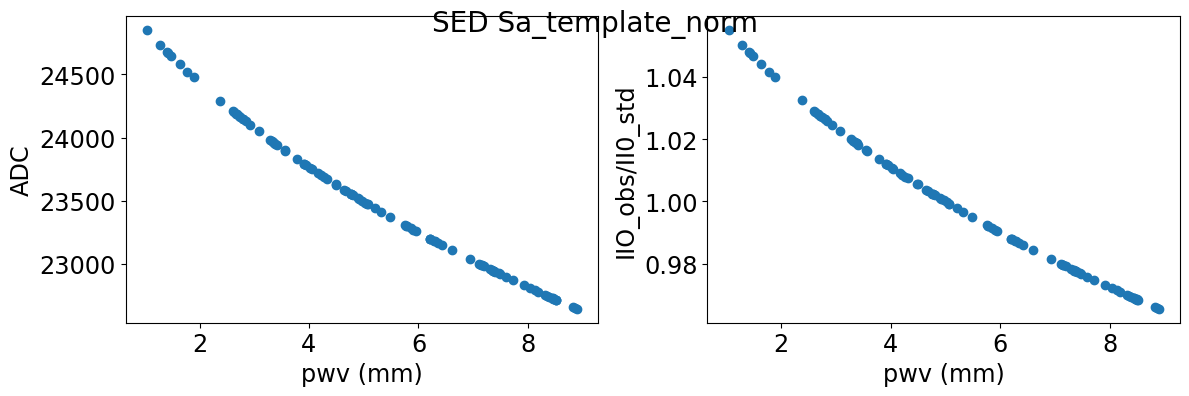

In [40]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].scatter(all_pwv,all_adc)
axs[0].set_xlabel("pwv (mm)")
axs[0].set_ylabel("ADC")
axs[1].scatter(all_pwv,all_ratioII0)
axs[1].set_xlabel("pwv (mm)")
axs[1].set_ylabel("IIO_obs/II0_std")
plt.tight_layout()
plt.suptitle(f"SED {sed_name}",fontsize=20)

Text(0.5, 1.0, 'Estimation of $1/F_{\\nu} dF_{\\nu}/d\\lambda$')

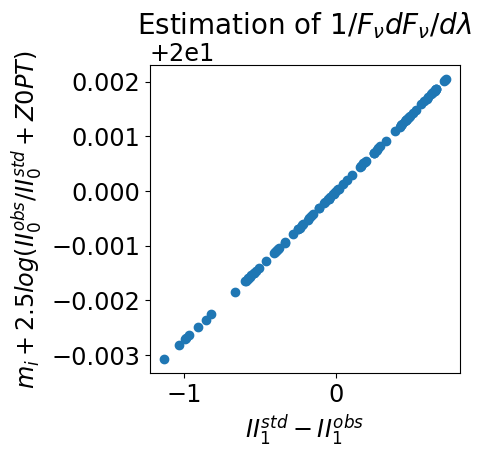

In [41]:
fig, axs = plt.subplots(1,1,figsize=(4,4))
y1 = -2.5*np.log10(all_adc) + 2.5*np.log10(all_ratioII0)+z0pt_std[selected_filter]
x1 = all_subII1
sed_name1 = sed_name
axs.scatter(x1,y1,label=sed_name1)
axs.set_xlabel("$II_1^{std} - II_1^{obs}$")
axs.set_ylabel("$m_i + 2.5log(II_0^{obs}/II_0^{std} + Z0PT$)")
axs.set_title("Estimation of $1/F_{\\nu} dF_{\\nu}/d\\lambda$",fontsize=20)

## Try another SED

In [42]:
df_SED

,type
name,
Sa_template_norm,galaxies
Sdm_template_norm0,galaxies
Ell2_template_norm,galaxies
quasar,quasar
km10_5250.fits_g45,stars
km10_4500.fits_g45,stars
km10_6000.fits_g45,stars
km10_7250.fits_g45,stars
km10_6500.fits_g45,stars


In [43]:
sed_name_old = sed_name
#sed_name = 'xspec_173'
#sed_name = 'Sa_template_norm'
#sed_name = 'Sdm_template_norm0'
#sed_name = 'Ell2_template_norm'
sed_name = 'quasar'

In [44]:
z=1
seds[sed_name].redshift_sed(z)

In [45]:
# Scale spectrum and recalculate magnitudes.
z = 20.0
flux_norm = seds[sed_name].calc_flux_norm(z, pc.bandpass_total_std['z'])
seds[sed_name].multiply_flux_norm(flux_norm)

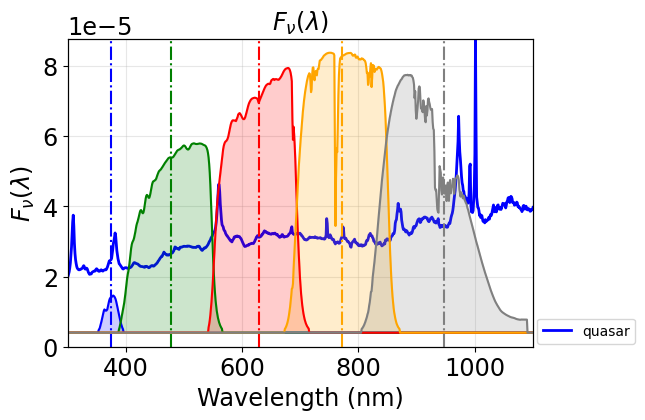

In [46]:
# Plot the seds
fig, ax = plt.subplots(1,1,figsize=(6,4))

wavel,fnu = seds[sed_name].get_sed_fnu()
ax.plot(wavel, fnu,"b-",label=sed_name,lw=2)
ax.legend(loc=(1.01, 0.01))
ax.set_xlim(300, 1100)

ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$F_\\nu (\lambda)$")
ax.set_title("$F_\\nu (\lambda)$")

indexes_sel = np.where(np.logical_and(wavel>WLMIN,wavel<WLMAX))[0]
flmax = np.max(fnu[indexes_sel])
ax.set_ylim(0,flmax)
                       

ax2 = ax.twinx()
for index,f in enumerate(filter_tagnames):
    
    ax2.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    ax2.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    ax2.set_yticks([])
    

In [47]:
all_adc = np.zeros(NOBS)
selected_filter = "z"
for idx,pwv in enumerate(all_pwv):
    lsst_band = pc.coll_bandpass_total_nonstd[idx][selected_filter]
    adcs_nonstd = seds[sed_name].calc_adu(lsst_band,photoparams)
    all_adc[idx] = adcs_nonstd

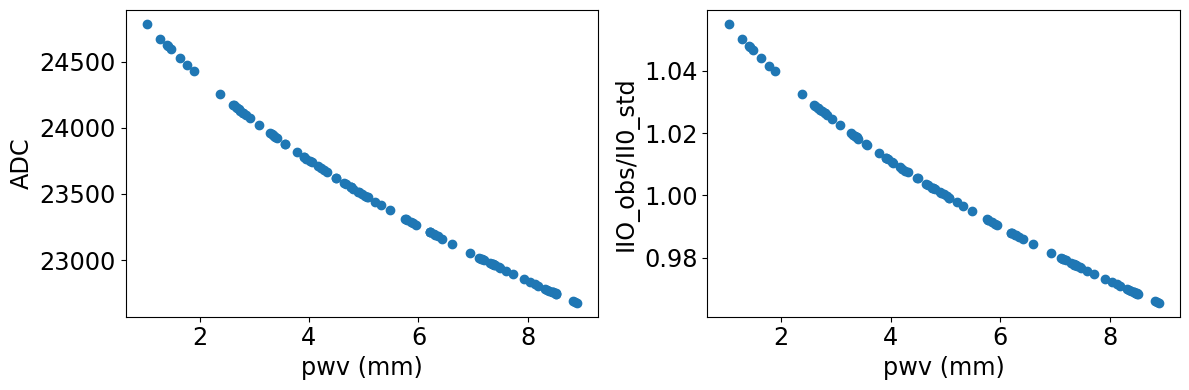

In [48]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].scatter(all_pwv,all_adc)
axs[0].set_xlabel("pwv (mm)")
axs[0].set_ylabel("ADC")
axs[1].scatter(all_pwv,all_ratioII0)
axs[1].set_xlabel("pwv (mm)")
axs[1].set_ylabel("IIO_obs/II0_std")
plt.tight_layout()

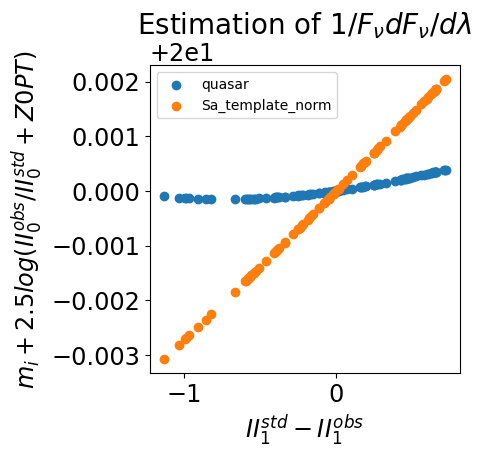

In [49]:
fig, axs = plt.subplots(1,1,figsize=(4,4))
y2 = -2.5*np.log10(all_adc) + 2.5*np.log10(all_ratioII0)+z0pt_std[selected_filter]
x2 = all_subII1
sed_name2 = sed_name
axs.scatter(x2,y2,label=sed_name2)
axs.scatter(x1,y1,label=sed_name1)
axs.set_xlabel("$II_1^{std} - II_1^{obs}$")
axs.set_ylabel("$m_i + 2.5log(II_0^{obs}/II_0^{std}  + Z0PT$)")
axs.set_title("Estimation of $1/F_{\\nu} dF_{\\nu}/d\\lambda$",fontsize=20)
axs.legend()

### Flat SED 

In [50]:
sed_flat = Sed()

In [51]:
sed_flat.set_flat_sed()
sed_name = 'flat'

In [52]:
fnu

array([1.30079432e-06, 1.31181795e-06, 1.32255086e-06, ...,
       1.32052062e-04, 1.32139094e-04, 1.32226109e-04])

In [53]:
# Scale spectrum and recalculate magnitudes.
z = 20.0
flux_norm = sed_flat.calc_flux_norm(z, pc.bandpass_total_std['z'])
sed_flat.multiply_flux_norm(flux_norm)

In [54]:
wavel,fnu = sed_flat.get_sed_fnu()

In [55]:
fnu

array([3.631e-05, 3.631e-05, 3.631e-05, ..., 3.631e-05, 3.631e-05,
       3.631e-05])

In [56]:
all_adc = np.zeros(NOBS)
selected_filter = "z"
for idx,pwv in enumerate(all_pwv):
    lsst_band = pc.coll_bandpass_total_nonstd[idx][selected_filter]
    adcs_nonstd = sed_flat.calc_adu(lsst_band,photoparams)
    all_adc[idx] = adcs_nonstd

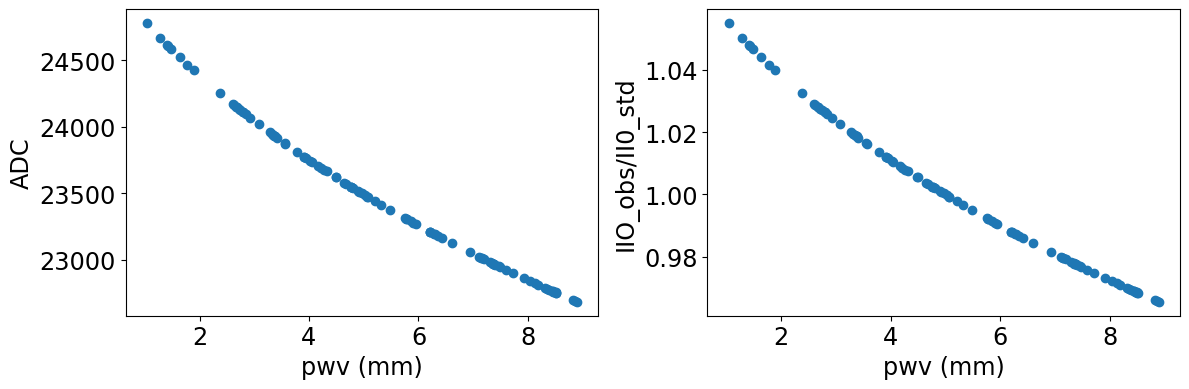

In [57]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].scatter(all_pwv,all_adc)
axs[0].set_xlabel("pwv (mm)")
axs[0].set_ylabel("ADC")
axs[1].scatter(all_pwv,all_ratioII0)
axs[1].set_xlabel("pwv (mm)")
axs[1].set_ylabel("IIO_obs/II0_std")
plt.tight_layout()

Text(0.5, 1.0, 'Estimation of $1/F_{\\nu} dF_{\\nu}/d\\lambda$')

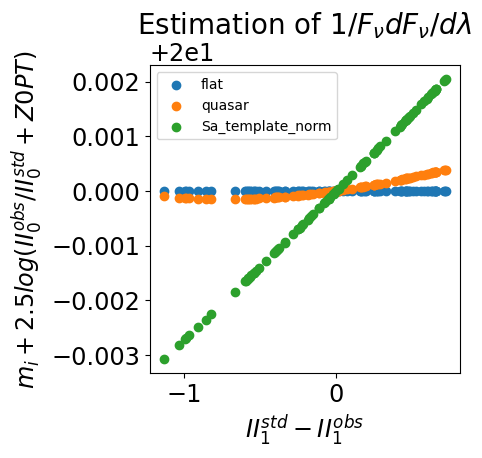

In [58]:
fig, axs = plt.subplots(1,1,figsize=(4,4))
y3 = -2.5*np.log10(all_adc) + 2.5*np.log10(all_ratioII0)+z0pt_std[selected_filter]
x3 = all_subII1
sed_name3 = sed_name
axs.scatter(x3,y3,label=sed_name3)
axs.scatter(x2,y2,label=sed_name2)
axs.scatter(x1,y1,label=sed_name1)
axs.set_xlabel("$II_1^{std} - II_1^{obs}$")
axs.set_ylabel("$m_i + 2.5log(II_0^{obs}/II_0^{std} + Z0PT$)")
axs.legend()
axs.set_title("Estimation of $1/F_{\\nu} dF_{\\nu}/d\\lambda$",fontsize=20)